In [1]:
!python3 download_models.py

In [2]:
import torch

from src.dataset import get_dataloaders
from src.utils import evaluate, set_random_seed, plot_confusion_matrix

import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
set_random_seed()
_, test_loader, class_names = get_dataloaders("./data/Places2_simp")

In [4]:
from src.models import load_vit_model

model_path = "./dino.pth"  # "vit.pth", "swin.pth", "dino.pth"
model = load_vit_model("dinov2").to("cuda")  # "dinov2", "vit_base", "swin"

state_dict = torch.load(model_path)
# Remove _orig_mod. from all keys since we are using torch.compile(model) while training
new_state_dict = {k.replace("_orig_mod.", ""): v for k, v in state_dict.items()}
model.load_state_dict(new_state_dict)

Some weights of Dinov2ForImageClassification were not initialized from the model checkpoint at facebook/dinov2-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<All keys matched successfully>

In [5]:
print("Top-1, Top-5")
evaluate(model, test_loader, "cuda")

Top-1, Top-5


(80.9, 97.6125)

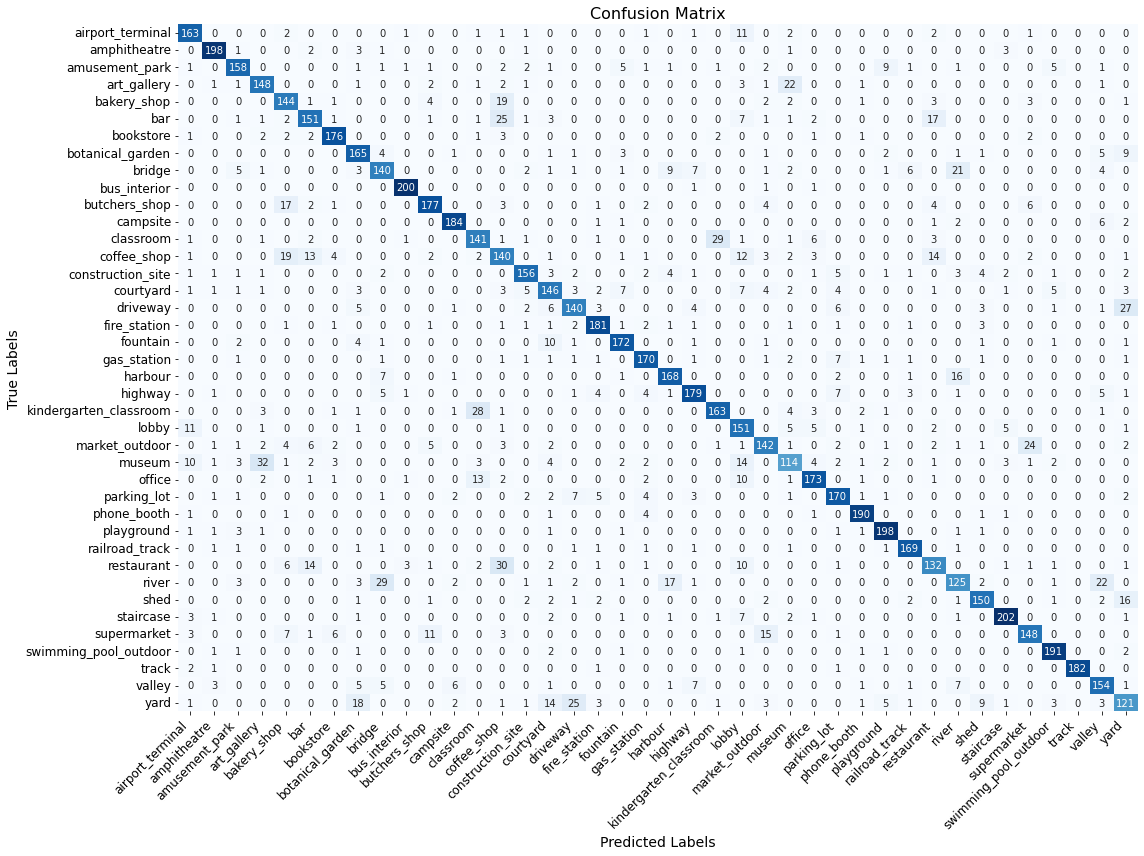

In [6]:
plot_confusion_matrix(
    model=model,
    dataloader=test_loader,
    class_names=class_names,
    device="cuda",
    save=False,
)

In [7]:
import torch
import matplotlib.pyplot as plt


def unnormalize(img_tensor):
    """Undo normalization for visualization."""
    mean = torch.tensor([0.4547, 0.4337, 0.4011]).view(3, 1, 1)
    std = torch.tensor([0.2266, 0.2237, 0.2316]).view(3, 1, 1)
    img = img_tensor * std + mean
    return torch.clamp(img, 0, 1)


def print_misclassified_grid(
    model, val_loader, class_names, device="cuda", max_to_show=12, cols=4
):
    model.eval()
    model.to(device)
    misclassified_images = []
    titles = []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images).logits
            preds = torch.argmax(outputs, dim=1)

            for img, label, pred in zip(images, labels, preds):
                if label != pred:
                    misclassified_images.append(unnormalize(img.cpu()))
                    titles.append(f"T: {class_names[label]}\nP: {class_names[pred]}")
                    if len(misclassified_images) >= max_to_show:
                        break
            if len(misclassified_images) >= max_to_show:
                break

    # Plot images in grid
    rows = (len(misclassified_images) + cols - 1) // cols
    fig, axs = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
    axs = axs.flatten()

    for ax, img, title in zip(axs, misclassified_images, titles):
        ax.imshow(img.permute(1, 2, 0).numpy())
        ax.set_title(title, fontsize=9)
        ax.axis("off")

    # Turn off unused axes
    for i in range(len(misclassified_images), len(axs)):
        axs[i].axis("off")

    plt.tight_layout()
    plt.show()

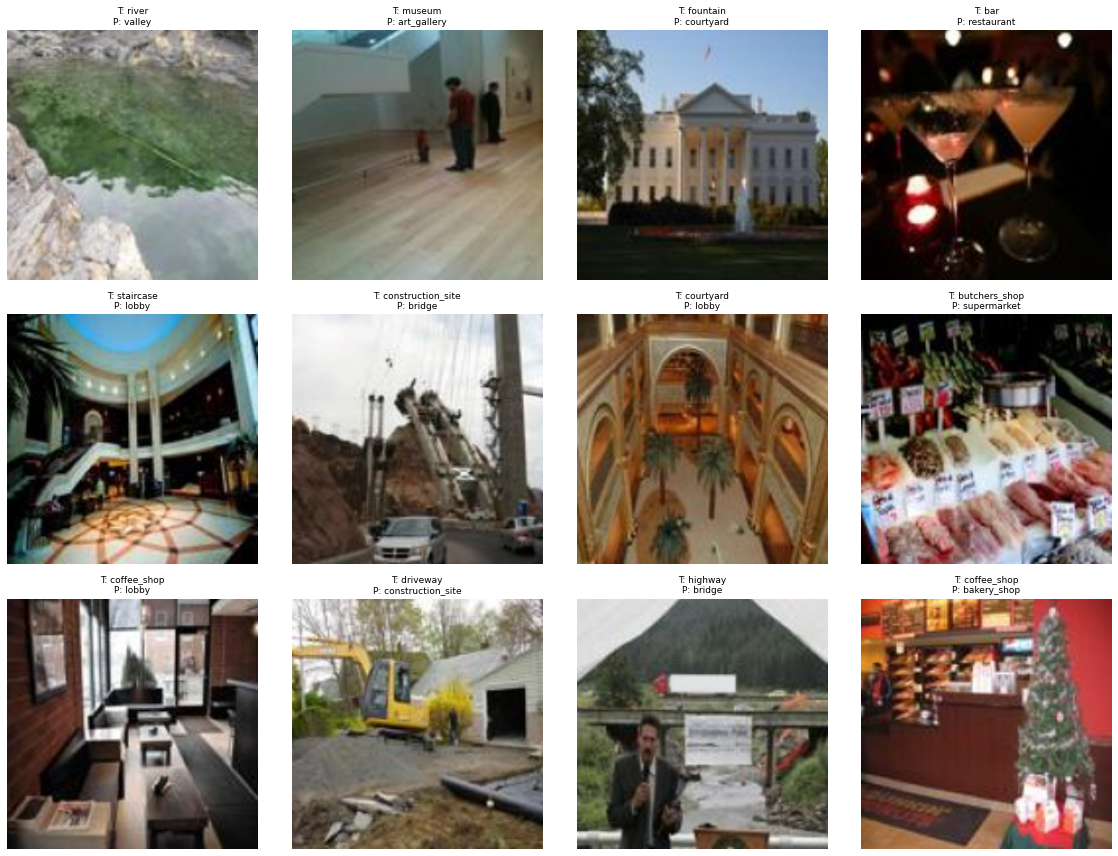

In [8]:
print_misclassified_grid(
    model, test_loader, class_names
)  # T = True Label, P = Predicted